In [838]:
# Imports
import pandas as pd
from pandas import read_csv
import copy
import numpy as np
import tensorflow as tf
from scipy.stats import zscore
from sklearn.ensemble import ExtraTreesClassifier
from tensorflow.keras.utils import to_categorical
from matplotlib.pyplot import figure
from matplotlib.dates import YearLocator
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from keras.layers import Dense, Dropout, Flatten, Lambda, Input

# Yahoo Finance data sourcer
import yfinance as yf

# Technical Analysis package (for Technical Indicator creation)
from ta import add_all_ta_features
from ta.utils import dropna

# Setting seeds for reproducibility
from numpy.random import seed
seed(22)
tf.random.set_seed(23)
np.random.seed(24)

In [839]:
# Yahoo! Finance data sourcing

def yahoo_sourcer(stocks, start_date, end_date):
    
    """
    Takes list of stocks, start_date (first date of stock pricing) 
    and end_date (last date of stock pricing) as input.
    
    Sources data from Yahoo! Finance via yfinance API.
    
    Restructures data so that the ticker becomes an individual column,
    not an overarching, stacked column.
    
    Adds in technical indicators as additional features, calculated by using
    the historical data for given list of stocks.
    
    Returns df.

    """    
    
    ftse_stocks = yf.download(stocks, 
                      start=start_date, 
                      end=end_date, 
                      progress=False, group_by='Ticker')
    
    ftse_stocks = ftse_stocks.copy(deep=True)
        
    # Changing the structure of the yfinance df.
    ftse_stocks = ftse_stocks.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

    # Saving to csv (needed to deal with issue of 'Date' not being a proper column header)
    ftse_stocks.to_csv('ftse_stocks.csv')

    # Reading csv, 'Date' now a column header.
    ftse_stocks = pd.read_csv('ftse_stocks.csv')

    # Adding all technical indicators as features
    ftse_stocks = add_all_ta_features(
        ftse_stocks, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    return ftse_stocks

In [840]:
ftse_stocks = yahoo_sourcer('3IN.L	EMG.L	ASL.L', '2010-08-01', '2021-08-01')

/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/ta/volume.py:319: RuntimeWarning: overflow encountered in double_scalars
  self._nvi.iloc[i] = self._nvi.iloc[i - 1] * (1.0 + price_change.iloc[i])
/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [841]:
# Checking data
ftse_stocks

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,volume_adi,volume_obv,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,2010-08-02,3IN.L,74.630592,157.488800,157.910995,156.925797,157.910995,183137,2.617458e+04,183137,...,-42.853824,0.000000,157.488800,0.000000,0.000000,0.000000,0.000000,-66.340256,0.000000,0.000000
1,2010-08-02,ASL.L,429.147003,539.000000,542.500000,533.500000,536.000000,91590,4.652792e+04,274727,...,-0.907737,0.000000,217.836206,0.000000,-4.141002,-0.828200,-3.312802,242.246560,123.036123,242.246560
2,2010-08-02,EMG.L,108.141357,223.300003,223.300003,217.699997,219.899994,4922697,4.969225e+06,-4647970,...,-82.785621,0.000000,224.666692,0.000000,70.547516,13.446943,57.100573,-58.571428,-88.119940,41.787862
3,2010-08-03,3IN.L,74.563858,157.348007,157.756195,156.925797,157.629501,303623,4.974352e+06,-4951593,...,-99.890498,0.000000,224.082690,0.000000,58.134306,22.384416,35.749891,-29.535152,-35.005621,-0.089399
4,2010-08-03,ASL.L,433.924103,545.000000,545.000000,536.330017,540.000000,57483,5.031835e+06,-4894110,...,-0.000000,0.000000,235.044391,0.000000,45.073599,26.922252,18.151346,246.366001,124.232584,246.056354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8335,2021-07-29,ASL.L,1531.367188,1542.000000,1546.000000,1520.099976,1522.000000,151402,-5.604577e+08,-19354174641,...,-0.294064,80.827983,772.844876,2.800000,2.067895,3.449772,-1.381876,402.280130,161.398781,879.117245
8336,2021-07-29,EMG.L,194.028549,197.850006,200.000000,190.399994,190.399994,6026447,-5.604577e+08,-19360201088,...,-99.110457,98.262100,760.088346,3.858271,20.393170,6.838451,13.554719,-87.169260,-205.332636,25.627985
8337,2021-07-30,3IN.L,301.352173,306.000000,307.500000,304.500000,307.000000,437025,-5.604577e+08,-19359764063,...,-91.159713,-145.451135,757.661462,1.324503,11.800857,7.830932,3.969924,54.662618,43.607590,94.299531
8338,2021-07-30,ASL.L,1539.312012,1550.000000,1554.000000,1538.000000,1538.000000,100021,-5.604577e+08,-19359664042,...,-0.292344,88.410629,774.569449,3.609626,2.642003,6.793147,-4.151143,406.535948,162.242511,884.196971


In [842]:
# Z-Score Normalisation

# Save 'Date' column as not normalising
date = ftse_stocks['Date']
# save 'Ticker' column as not normalising
tickers = ftse_stocks['Ticker']

# Drop columns
ftse_stocks = ftse_stocks.drop(['Date', 'Ticker'], axis=1)

# Normalisation
ftse_stocks = ftse_stocks.apply(lambda x: x if np.std(x) == 0 else zscore(x))

# Add 'Date' column back in to data
ftse_stocks.insert(0, 'Date', date)
# Add 'Ticker' column back in to data
ftse_stocks.insert(1, 'Ticker', tickers)

data = ftse_stocks

/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:2568: RuntimeWarning: invalid value encountered in true_divide
  z = (a - mn) / std


In [843]:
data

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,volume_adi,volume_obv,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,2010-08-02,3IN.L,-0.788004,-0.720482,-0.723109,-0.717895,-0.719404,-0.519214,2.235957,2.079144,...,0.469100,-0.008083,-2.932385,-0.039123,0.112242,0.160163,-0.000542,-0.932270,-0.000019,-0.720482
1,2010-08-02,ASL.L,0.056917,0.165071,0.162663,0.162503,0.158011,-0.537296,2.236056,2.079160,...,1.430537,-0.008083,-2.451269,-0.039123,-0.199764,0.071393,-0.393034,0.682053,0.833806,0.165071
2,2010-08-02,EMG.L,-0.708137,-0.567723,-0.572508,-0.575811,-0.575549,0.416929,2.260132,2.078307,...,-0.446167,-0.008083,-2.396814,-0.039123,5.427673,1.601468,6.764588,-0.891628,-0.597214,-0.567723
3,2010-08-03,3IN.L,-0.788163,-0.720808,-0.723466,-0.717895,-0.720058,-0.495416,2.260157,2.078255,...,-0.838224,-0.008083,-2.401469,-0.039123,4.492395,2.559427,4.235014,-0.739730,-0.237254,-0.720808
4,2010-08-03,ASL.L,0.068303,0.178998,0.168421,0.169119,0.167293,-0.544033,2.260438,2.078265,...,1.451343,-0.008083,-2.314078,-0.039123,3.508330,3.045814,2.149983,0.703603,0.841914,0.178998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8335,2021-07-29,ASL.L,2.683846,2.493204,2.473889,2.469089,2.446179,-0.525482,-0.505212,-1.274603,...,1.444603,1.018115,1.973501,0.757753,0.268048,0.529925,-0.164263,1.519243,1.093792,2.493204
8336,2021-07-29,EMG.L,-0.503442,-0.626796,-0.626172,-0.639636,-0.644009,0.634938,-0.505212,-1.275648,...,-0.820345,1.239459,1.871800,1.058936,1.648774,0.893140,1.605387,-1.041233,-1.391572,-0.626796
8337,2021-07-30,3IN.L,-0.247657,-0.375762,-0.378581,-0.372880,-0.373420,-0.469067,-0.505212,-1.275572,...,-0.638108,-1.854741,1.852452,0.337829,1.001382,0.999518,0.469805,-0.299262,0.295513,-0.375762
8338,2021-07-30,ASL.L,2.702781,2.511773,2.492315,2.510938,2.483309,-0.535631,-0.505212,-1.275555,...,1.444642,1.114384,1.987250,0.988172,0.311305,0.888284,-0.492359,1.541507,1.099510,2.511773


In [844]:
# Convert data to type float32

# Save 'Date' and 'Ticker'
x_train_ticker = copy.deepcopy(data.iloc[:,1])
x_train_date = copy.deepcopy(data.iloc[:,0])

# Change all columns aside from 'Date' and 'Ticker' to float32
x_train = copy.deepcopy(data.iloc[:,2:]).astype('float32')

# Re-join 'Date' and 'Ticker'
x_train = x_train.join(x_train_date)
x_train = x_train.join(x_train_ticker)

In [845]:
# Creating individual stock variables

three_infra = x_train.loc[x_train['Ticker'] == '3IN.L']
man_group = x_train.loc[x_train['Ticker'] == 'EMG.L']
aberforth = x_train.loc[x_train['Ticker'] == 'ASL.L']

In [846]:
# Creating list of all stocks (for running through SVM and LR)

list_all_shares = [three_infra, man_group, aberforth]

In [847]:
# Basic statistics

three_infra.describe()

,Adj Close,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
count,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,...,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000
mean,-0.575385,-0.563436,-0.565469,-0.561610,-0.563519,-0.422407,0.000364,0.000428,0.000044,0.012927,...,-0.617382,-1.333111,-0.032820,-0.005660,0.032978,0.057189,-0.011359,-0.249388,0.298166,-0.563436
std,0.170299,0.104714,0.105257,0.104096,0.104749,0.113280,1.000491,1.000324,0.981149,0.958624,...,0.125295,0.430001,0.990752,0.583758,0.881847,0.997465,0.730030,0.255559,0.243809,0.104714
min,-0.788322,-0.721135,-0.723758,-0.718224,-0.721691,-0.555387,-0.529295,-1.275572,-3.053692,-8.158538,...,-0.840734,-2.573863,-2.932385,-8.304325,-3.703731,-5.058446,-2.160110,-0.932270,-0.433273,-0.721135
25%,-0.728410,-0.656452,-0.658928,-0.653733,-0.656695,-0.483661,-0.505212,-0.876023,-0.688421,-0.404185,...,-0.696825,-1.652564,-0.765583,-0.201439,-0.518238,-0.567007,-0.480071,-0.411923,0.193896,-0.656452
50%,-0.611865,-0.572984,-0.574377,-0.570683,-0.572772,-0.451425,-0.505212,-0.231544,0.017646,0.198669,...,-0.622000,-1.416110,0.039241,-0.010263,-0.040869,0.013973,-0.083309,-0.216632,0.361415,-0.572984
75%,-0.439473,-0.498587,-0.499532,-0.496678,-0.497962,-0.403015,-0.239317,0.704985,0.677994,0.649187,...,-0.545415,-0.972437,0.686382,0.233963,0.514286,0.662681,0.373820,-0.063734,0.468665,-0.498587
max,-0.237095,-0.349068,-0.349792,-0.348331,-0.350213,1.055526,2.882832,2.079144,3.764249,1.748989,...,0.469100,-0.008083,1.893607,8.223422,4.762683,5.253482,4.417596,0.329498,0.685190,-0.349068


In [848]:
man_group.describe()

,Adj Close,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
count,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,...,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000
mean,-0.706608,-0.738804,-0.737175,-0.739980,-0.738544,0.955351,-0.000717,-0.000877,-0.001503,-0.285497,...,-0.784448,0.734238,-0.017852,-0.011706,0.540075,0.060003,0.782919,-1.024539,-1.313135,-0.738804
std,0.083176,0.113058,0.113404,0.112487,0.113151,1.269781,0.999507,0.999894,0.991607,1.118330,...,0.136286,0.266784,0.993117,1.370208,0.978190,0.993474,0.986490,0.047890,0.282680,0.113058
min,-0.881410,-0.939226,-0.938250,-0.941928,-0.940821,-0.555387,-0.528454,-1.276651,-3.092627,-9.820608,...,-0.840734,-1.187926,-2.396813,-9.399051,-3.756126,-5.005970,-2.301169,-1.071631,-1.800281,-0.939226
25%,-0.773808,-0.815624,-0.813563,-0.816411,-0.815737,0.244151,-0.505212,-0.876772,-0.691089,-0.771318,...,-0.835735,0.534302,-0.751957,-0.733870,-0.092327,-0.576912,0.162214,-1.048420,-1.468319,-0.815624
50%,-0.689633,-0.743783,-0.742712,-0.745309,-0.743565,0.640503,-0.505212,-0.233555,0.021990,-0.071403,...,-0.830207,0.767806,0.053838,0.006171,0.457792,0.005212,0.653351,-1.041188,-1.391116,-0.743783
75%,-0.644983,-0.689352,-0.688253,-0.690578,-0.689493,1.245655,-0.240579,0.697225,0.692186,0.458778,...,-0.819731,0.930299,0.701805,0.722073,1.061058,0.651604,1.267754,-1.030106,-1.287621,-0.689352
max,-0.503208,-0.364156,-0.360156,-0.366567,-0.363673,24.102831,2.882168,2.078307,3.848197,1.580176,...,-0.113381,1.517881,1.913034,6.489610,5.822708,5.191590,6.772568,-0.841729,-0.456785,-0.364156


In [849]:
aberforth.describe()

,Adj Close,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
count,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,...,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000,2780.000000
mean,1.281993,1.302240,1.302645,1.301590,1.302067,-0.532942,0.000374,0.000448,0.001459,0.272571,...,1.401831,0.598873,0.050673,0.017366,-0.573052,-0.117193,-0.771561,1.273927,1.014968,1.302240
std,0.700288,0.645981,0.645104,0.647731,0.646542,0.016202,1.000498,1.000320,1.027199,0.821845,...,0.064028,0.262870,1.014516,0.884514,0.803235,0.999269,0.534921,0.444663,0.131605,0.645981
min,-0.003805,0.060618,0.069384,0.065503,0.062632,-0.555387,-0.529483,-1.275555,-3.237335,-6.718370,...,0.431873,-1.302617,-2.451269,-10.668017,-3.988484,-5.181443,-2.462040,0.321897,0.681598,0.060618
25%,0.709187,0.779600,0.781926,0.777959,0.777336,-0.542443,-0.505212,-0.876009,-0.704916,-0.082721,...,1.386744,0.465423,-0.712722,-0.355968,-1.080575,-0.743742,-1.103711,0.958188,0.931012,0.779600
50%,1.345523,1.404575,1.402457,1.405853,1.407685,-0.537084,-0.505212,-0.231529,0.012276,0.432582,...,1.418713,0.637728,0.129188,0.011797,-0.632566,-0.175084,-0.813557,1.297112,1.033933,1.404575
75%,1.842629,1.792211,1.787546,1.789107,1.787112,-0.529364,-0.239120,0.705005,0.695544,0.816980,...,1.438559,0.775827,0.786080,0.435208,-0.133318,0.498143,-0.481675,1.601052,1.114571,1.792211
max,2.769053,2.576766,2.639717,2.595103,2.613266,-0.370862,2.881475,2.079160,3.760090,1.779702,...,1.451343,1.453279,2.019524,7.933351,3.743100,5.030879,2.611707,2.334537,1.276937,2.576766


In [850]:
# Data preparation function
# Returns x_train, df_train_y, x_val, df_val_y, x_test, df_test_y, top 5 important_features

def prep_data_all(share):
    
        # Creating the 'Direction' column      
        share['Direction'] = (share['Open'] > share['Open'].shift(1)).astype(int)
        
        # y variable is 'Direction' column only  
        share_y = share.iloc[:,-1]
        
        # x variable drops 'Date', 'Ticker', 'Direction' and 'volume_nvi' columns
        share_x = share.iloc[ : , :-3]
        share_x.drop('volume_nvi', inplace=True, axis=1)

        # Feature Selection
        important_features = []
        extra_trees = ExtraTreesClassifier()
        extra_trees.fit(share_x, share_y)

        # Importances stored as list of tuples in form (feature name, feature importance score)
        importances = [*zip(share_x.columns, extra_trees.feature_importances_)]

        # Sorting the list of importances by their score (keeping their column names)
        features_imp = sorted(importances, key=lambda x: x[1],reverse=True)

        # Appending top 5 feature names to a list
        for i in range(0,5):
            important_features.append(features_imp[i][0])

        # Training Data, first 1526 observations
        x_train = share.iloc[:1526]
        df_train_y = x_train.iloc[:, 91]
        x_train = x_train.loc[:, important_features]

        # One-hot encoding train y, two classes
        df_train_y = to_categorical(df_train_y,2)

        # Test Data, final 26 observations
        x_test = share.iloc[2754: ]
        df_test_y = x_test.iloc[:, 91]
        x_test = x_test.loc[:, important_features]

        # One-hot encoding test y, two classes
        df_test_y = to_categorical(df_test_y,2)
    
        return x_train, df_train_y, x_test, df_test_y, important_features

In [851]:
# Preparing each stock

three_infra_prep = prep_data_all(three_infra)
man_group_prep = prep_data_all(man_group)
aberforth_prep = prep_data_all(aberforth)

<ipython-input-850-fd21d7fd0103>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  share['Direction'] = (share['Open'] > share['Open'].shift(1)).astype(int)
<ipython-input-850-fd21d7fd0103>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  share['Direction'] = (share['Open'] > share['Open'].shift(1)).astype(int)
<ipython-input-850-fd21d7fd0103>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [852]:
aberforth_prep

(      trend_cci  trend_aroon_up  volatility_bbp  momentum_roc  momentum_stoch
 1      0.981777       -1.357916        1.032799     -0.039123        1.430537
 4      1.234805       -1.002651        1.269755     -0.039123        1.451343
 7      1.322847       -0.647386        1.336557     -0.039123        1.445482
 10     1.373712       -0.292121        1.376526     -0.039123        1.451343
 13     1.389044       -0.292121        1.372619      0.356886        1.426329
 ...         ...             ...             ...           ...             ...
 4564   1.449824        1.365782        1.450858      1.195706        1.413669
 4567   1.456836        1.365782        1.445948      0.815397        1.418678
 4570   1.437558        1.365782        1.429335      0.302054        1.421164
 4573   1.426385        1.365782        1.416994      0.215488        1.416319
 4576   1.414605        1.010517        1.405284      0.101767        1.416319
 
 [1526 rows x 5 columns],
 array([[1., 0.],
      

In [853]:
# Printing the shape of training, validation and test data

x_train = three_infra_prep[0].shape
df_train_y = three_infra_prep[1].shape
x_test = three_infra_prep[2].shape
df_test_y = three_infra_prep[3].shape

print("The shape of a stock's x training data is:",x_train)
print("The shape of a stock's y training data is:",df_train_y)
print("The shape of a stock's x test data is:",x_test)
print("The shape of a stock's y test data is:",df_test_y)

The shape of a stock's x training data is: (1526, 5)
The shape of a stock's y training data is: (1526, 2)
The shape of a stock's x test data is: (26, 5)
The shape of a stock's y test data is: (26, 2)


In [854]:
# Function to create subplots of each feature

def plot_features_tight(data, name, period):
    
    # Creating variable of plot
    plotter = data.plot(subplots=True, figsize=(30,20))
    
    # Iterating to ensure that legend size changes for all subplots
    # only changes size of last subplot's legend if you don't
    for a in plotter:
        a.legend(loc='best', prop={'size': 30})
        
    # Setting x label and size  
    plt.xlabel('Time'+period, fontsize=40)
    
    # Layout style
    plt.tight_layout()
    
    # Title
    plt.suptitle(name+ ": important features plotted over time", y=1.02, fontsize=40)
    plt.show()

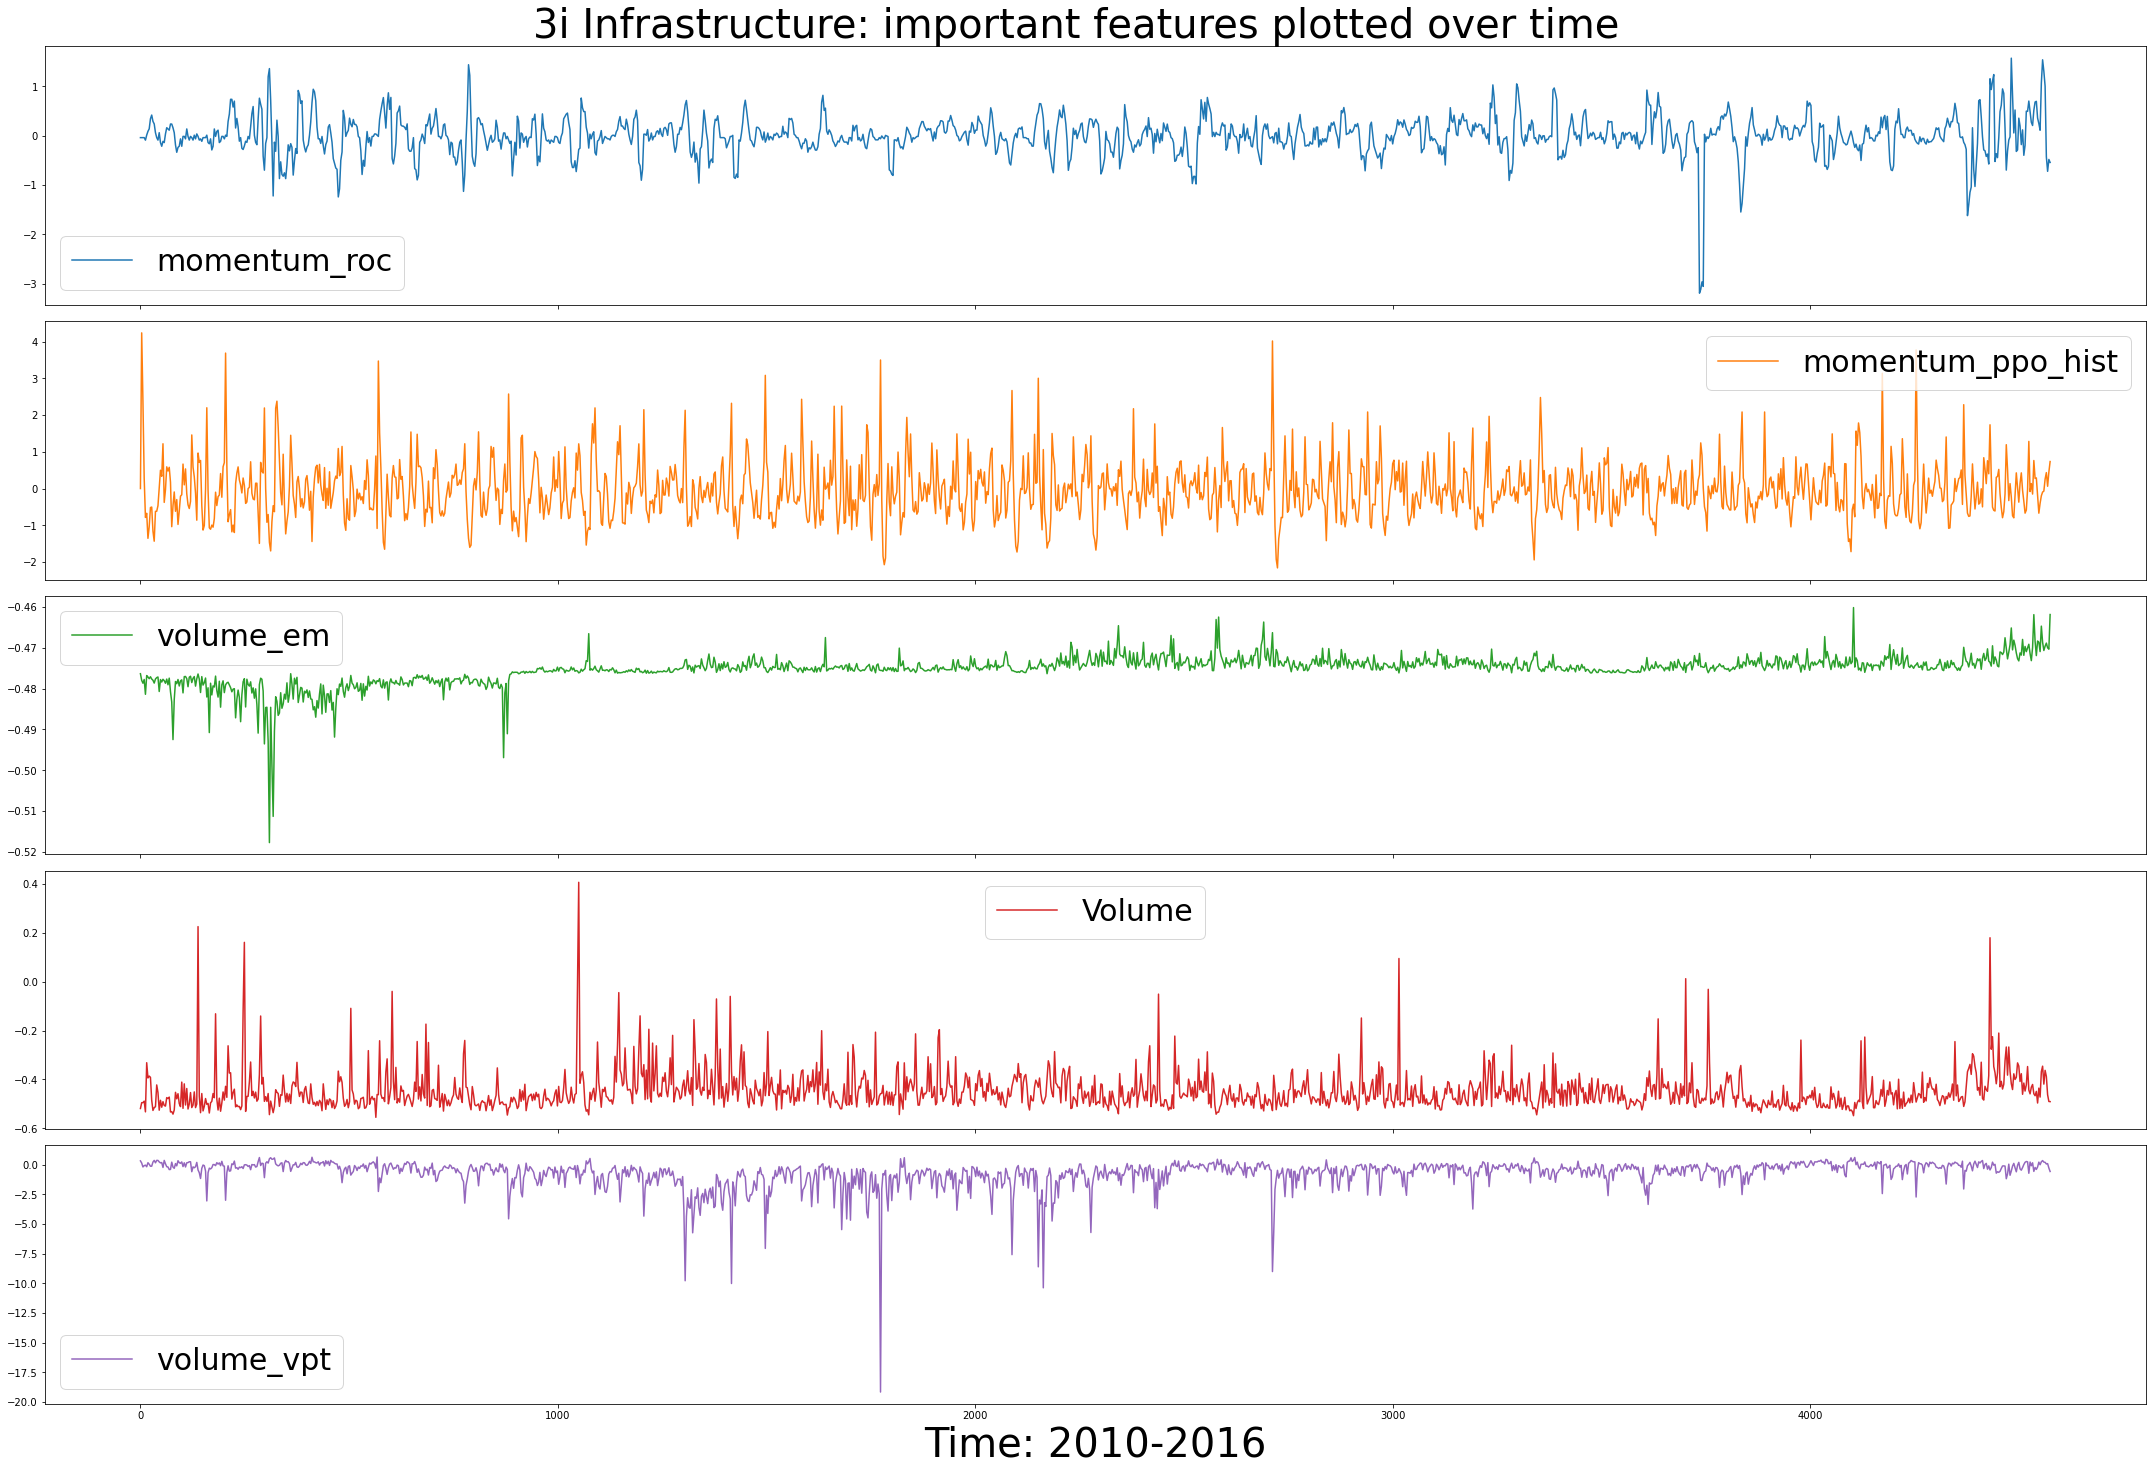

In [855]:
# Plotting training data for 3i
plot_features_tight(three_infra_prep[0], '3i Infrastructure', period=': 2010-2016')

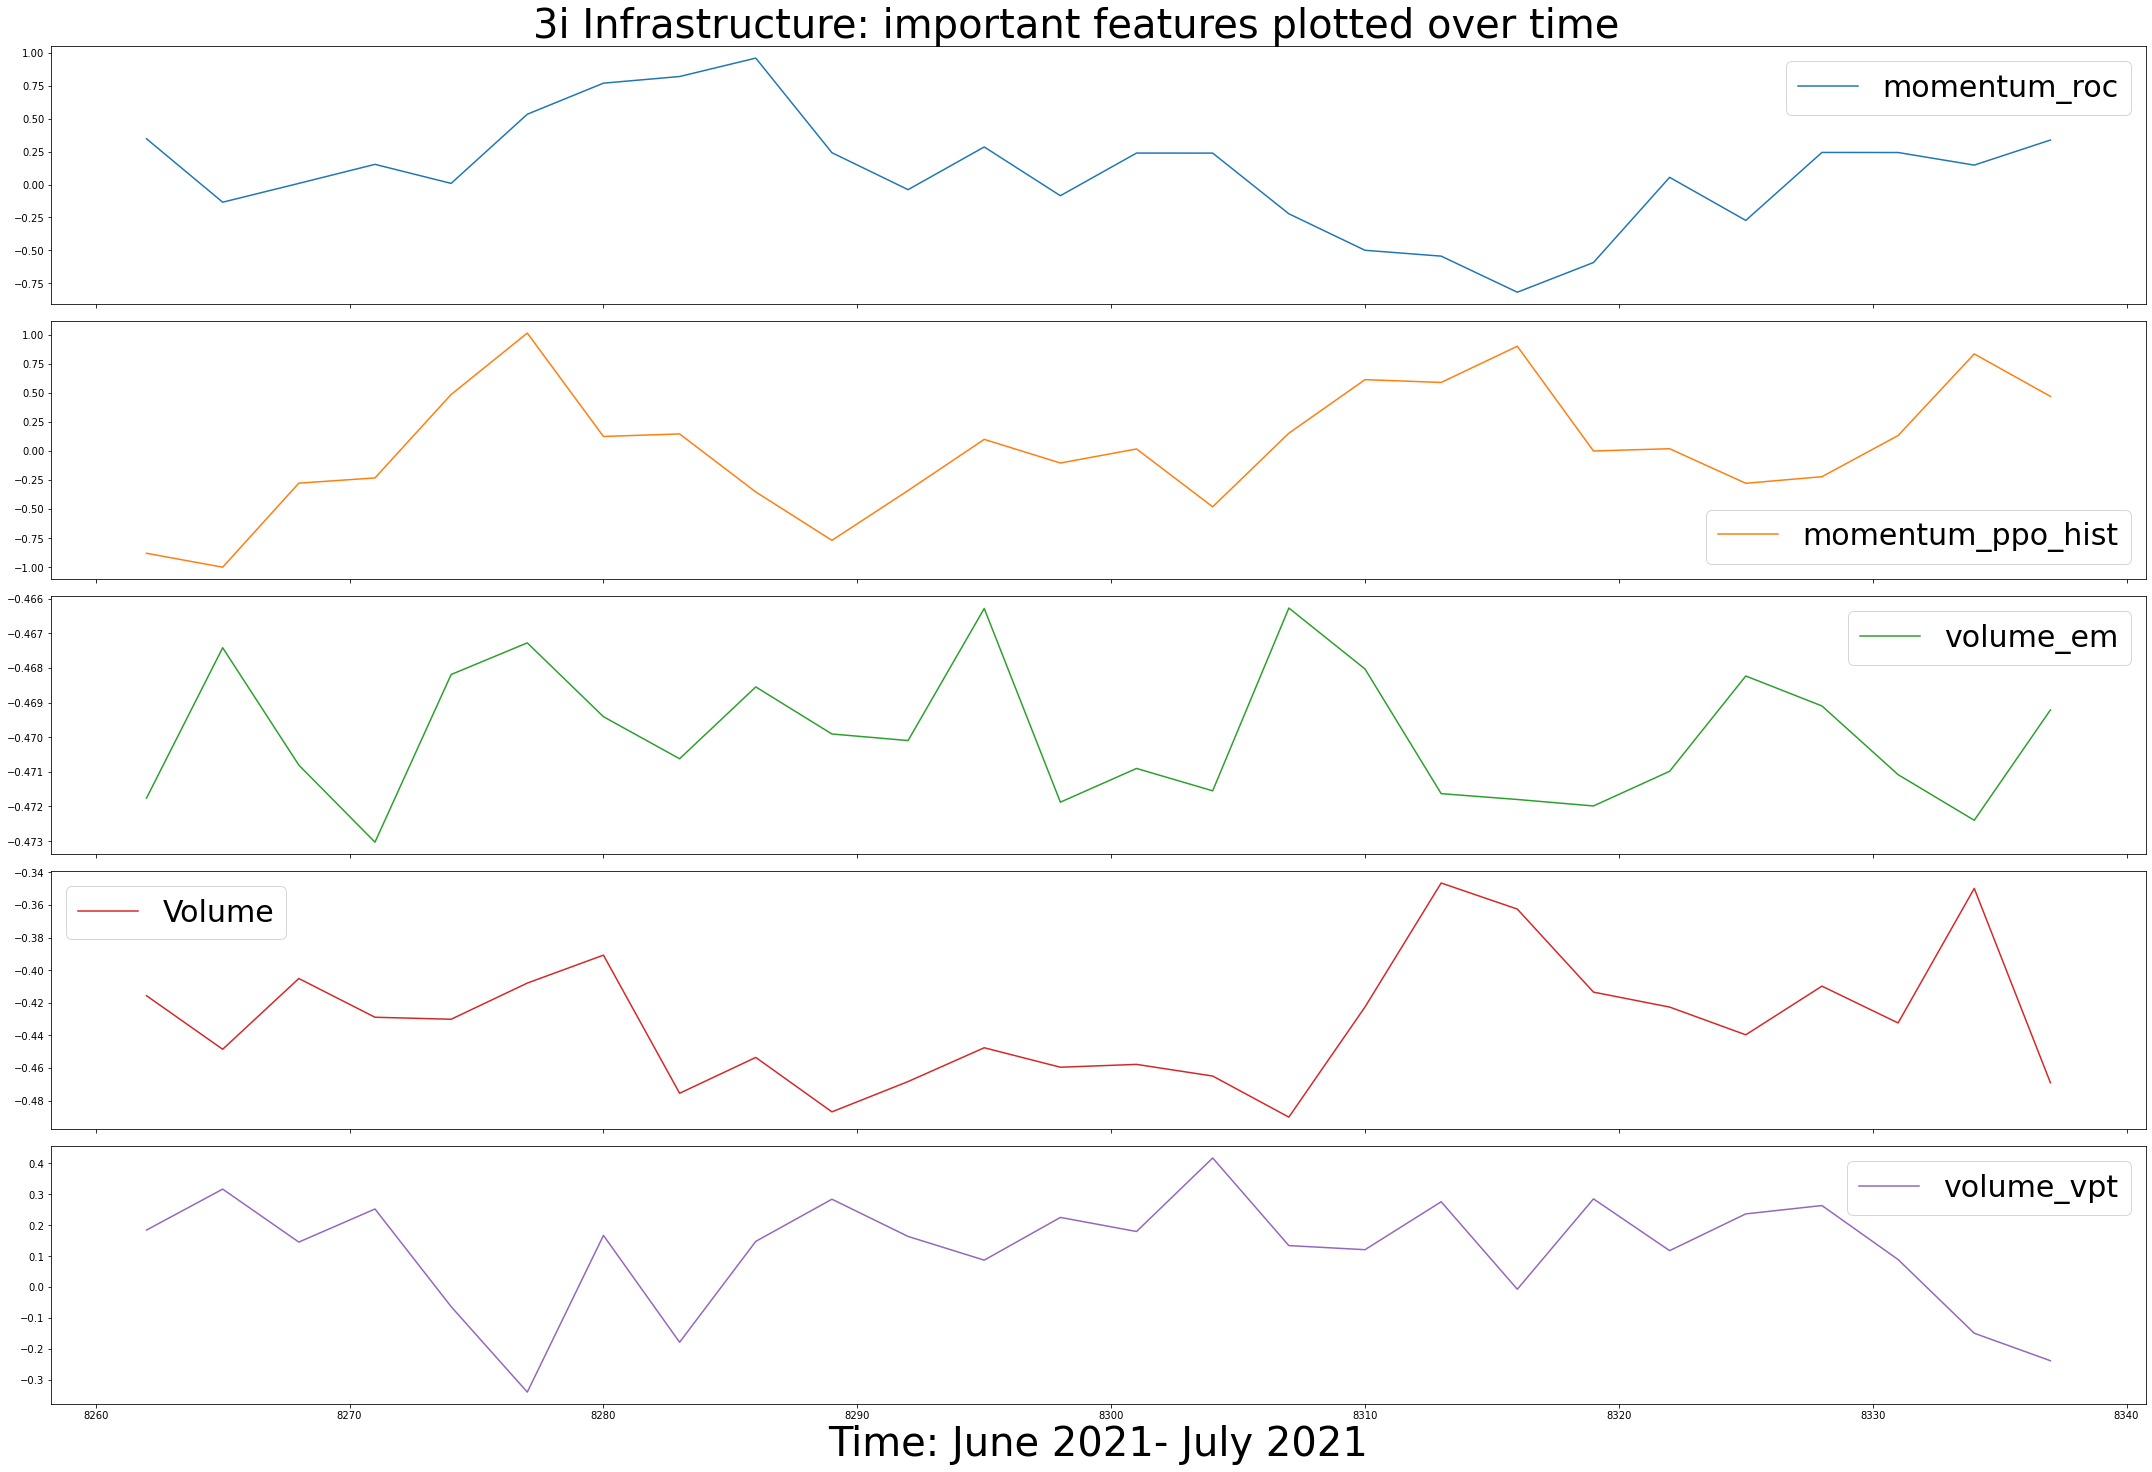

In [856]:
# Plotting test data for 3i

plot_features_tight(three_infra_prep[2], '3i Infrastructure', period=': June 2021- July 2021')

In [857]:
# Function to plot graph of particular feature values over time
# Takes data (stock feature) as input
# Shows a graph of movement of inputted feature over time
# by training, validation and test data

def plot_stock_movements(data, name, measure, date):
    
    # Data configuration (training, validation and test)
    dates = date
    date1 = dates[:1526]
    date2 = dates[1526:1858]
    date3 = dates[1858: ]
    
    # Figure size
    figure(figsize=(8, 6), dpi=100)
    plt.plot(date1, data.iloc[:1526])
    plt.plot(date2, data.iloc[1526:1858])
    plt.plot(date3, data.iloc[1858: ])

    # Setting year and ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(YearLocator(1))
    ax.set_yticklabels([])    
    
    # Plotting
    plt.title(name+": "+measure+' over time')
    plt.ylabel(measure)
    plt.xlabel('date')
    plt.xticks(rotation=45)
    plt.legend(['Training data', 'Validation data', 'Test data'], loc='upper left')
    
    # Remove 'None' return value
    return ""
    plt.show()

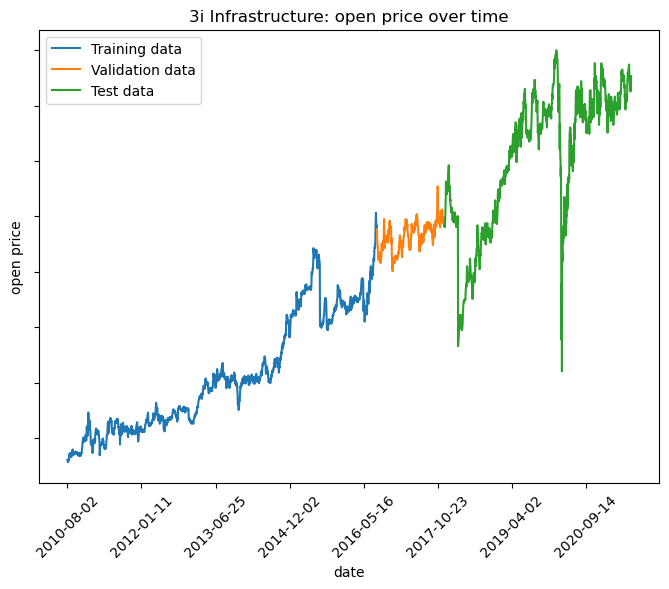

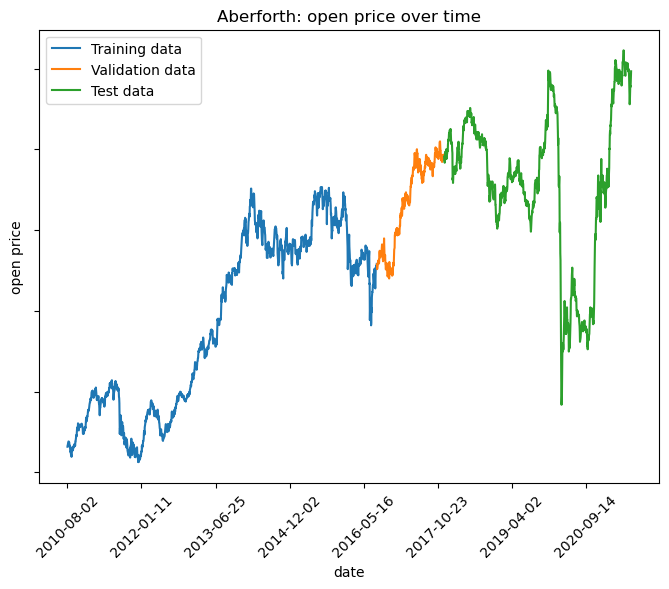

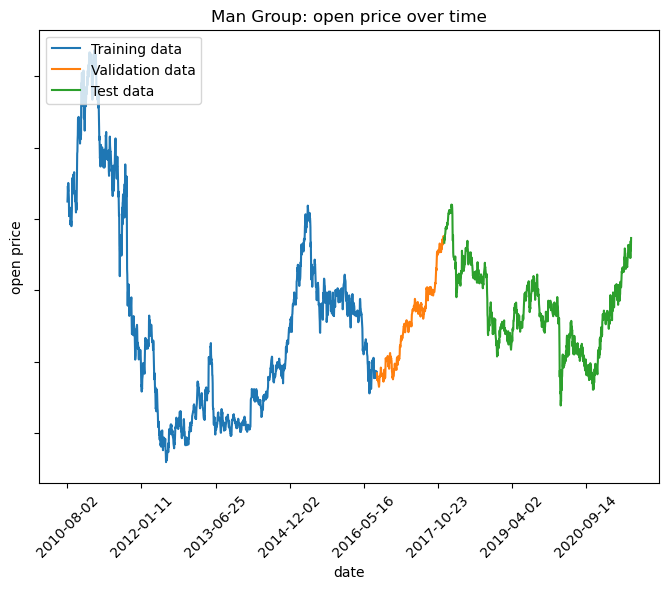

In [858]:
# Visualising Open prices
print(plot_stock_movements(data=three_infra['Open'], name='3i Infrastructure', 
                           measure='open price', date=three_infra['Date']))

print(plot_stock_movements(data=aberforth['Open'], name='Aberforth', 
                           measure='open price', date=aberforth['Date']))

print(plot_stock_movements(data=man_group['Open'], name='Man Group', 
                           measure='open price', date=man_group['Date']))

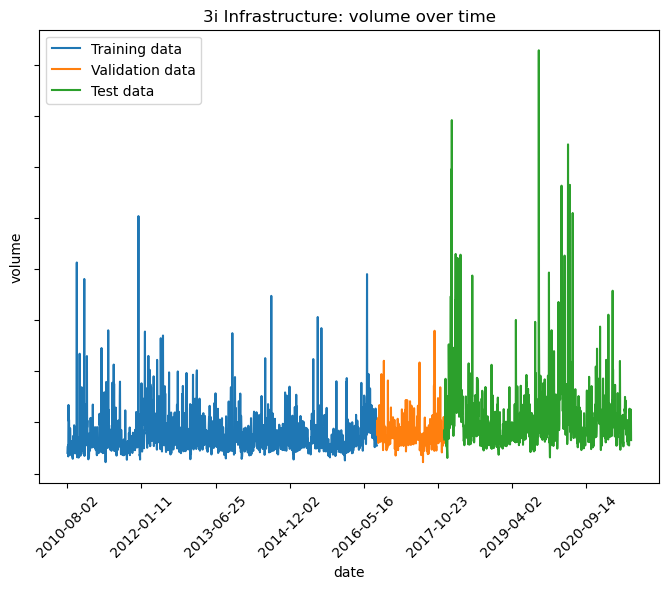

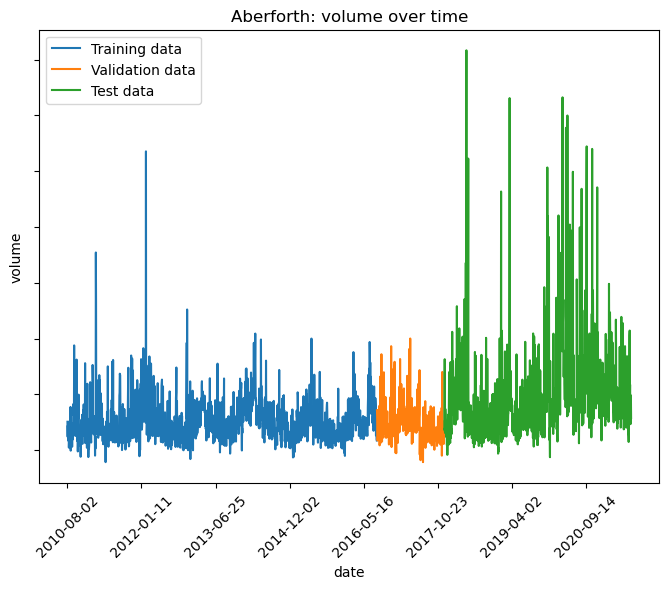

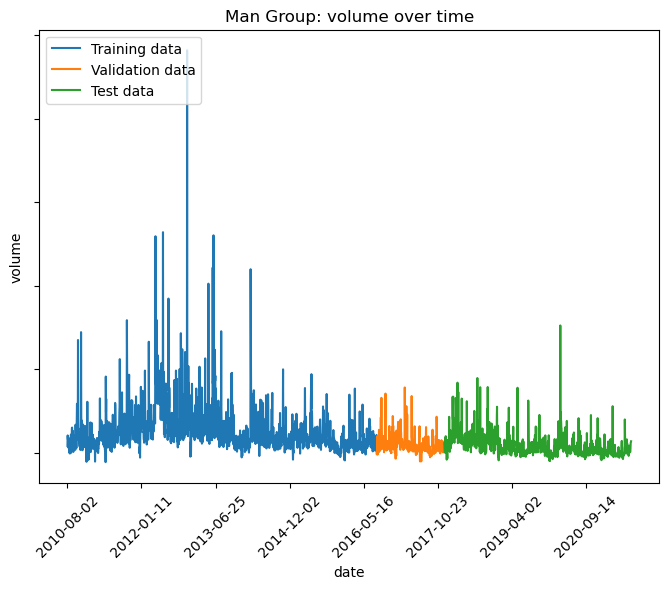

In [859]:
# Visualising volumes
print(plot_stock_movements(data=three_infra['Volume'], name='3i Infrastructure', 
                           measure='volume', date=three_infra['Date']))

print(plot_stock_movements(data=aberforth['Volume'], name='Aberforth', 
                           measure='volume', date=aberforth['Date']))

print(plot_stock_movements(data=man_group['Volume'], name='Man Group', 
                           measure='volume', date=man_group['Date']))

In [860]:
share_names = ['3i Infrastructure', 'Man Group', 'Aberforth']
title = ['Accuracy %']

In [861]:
# SVM Model

# Creating list to hold SVM model accuracy
svm_accuracies = []

# SVM function, takes list of stocks as input
# appends results to above list, along with names of stocks
def svm_model(shares_list):
    for i in shares_list:
        mks_svm = i[['Open', 'Volume', 'momentum_ppo_hist', 'volatility_bbp', 'Close']]
        mks_svm_y = i[['Direction']]

        classifier = svm.SVC(kernel='poly')
        classifier.fit(mks_svm[:1858], mks_svm_y[:1858].values.ravel())
        predictions = classifier.predict(mks_svm[2754:])

        svm_accuracies.append(round(metrics.accuracy_score(mks_svm_y[2754:], predictions)*100))

In [862]:
svm_model(list_all_shares)

svm_results = pd.DataFrame(svm_accuracies, share_names, title)
svm_results

,Accuracy %
3i Infrastructure,50
Man Group,50
Aberforth,62


In [863]:
# Naive Logistic Regression model
pd.set_option('display.max_rows', 177)

# Creating list to hold Logistic Regression model accuracy
lr_accuracies = []

# Function to build LR model
# Takes input of share list
def log_reg(shares_list):
    for i in shares_list:
        mks_lr = i[['Open', 'Volume', 'momentum_ppo_hist', 'volatility_bbp', 'Close']]
        mks_lr_y = i[['Direction']]
 
        regression = LogisticRegression()
        regression.fit(mks_lr[:1858], mks_lr_y[:1858].values.ravel())
        y_pred = regression.predict(mks_lr[2754:])
        
        lr_accuracies.append(round(metrics.accuracy_score(mks_lr_y[2754:], y_pred)*100))

In [864]:
log_reg(list_all_shares)

log_reg_results = pd.DataFrame(lr_accuracies, share_names, title)
log_reg_results

,Accuracy %
3i Infrastructure,58
Man Group,50
Aberforth,77


In [865]:
# MLP Model

def mlp_model(data, activation1, dense1, dense2, dense3, epo, bsize):

    # Creating the model
    model = Sequential()
    model.add(Dense(dense1, input_dim=5, activation=activation1))
    model.add(Dense(dense2, activation=activation1))
    model.add(Dense(dense3, activation='sigmoid'))
    
    # Flattening
    model.add(Flatten())
    
    # Compiling and fitting          
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    # fitting the training data (data[0])
    # and the the training y values (data[1])
    history = model.fit(data[0], data[1], epochs = epo, batch_size=bsize)

    pred = model.predict_classes(data[2])
    
    pred = to_categorical(pred,2)

    accuracy = accuracy_score((data[3]), (pred))

    return accuracy

In [866]:
three_infra_mlp = mlp_model(three_infra_prep, 'relu', dense1=70, dense2=30, dense3=1, epo=10, bsize=25)

Epoch 1/10
62/62 [==============================] - 1s 2ms/step - loss: 0.6940
Epoch 2/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 3/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 4/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 5/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 7/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 8/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 9/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 10/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932


/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [867]:
man_group_mlp = mlp_model(man_group_prep, 'relu', dense1=70, dense2=30, dense3=1, epo=10, bsize=25)

Epoch 1/10
62/62 [==============================] - 1s 2ms/step - loss: 0.6946
Epoch 2/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 3/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 4/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 5/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 7/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 8/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 9/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 10/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932


/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [868]:
aberforth_mlp = mlp_model(aberforth_prep, 'relu', dense1=70, dense2=30, dense3=1, epo=10, bsize=25)

Epoch 1/10
62/62 [==============================] - 1s 2ms/step - loss: 0.6941
Epoch 2/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 3/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 4/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 5/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6931
Epoch 7/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6932
Epoch 8/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6931
Epoch 9/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6931
Epoch 10/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6931


/Users/geoff/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [869]:
list_mlp_accuracies = [three_infra_mlp, man_group_mlp, aberforth_mlp]
list_mlp_accuracies = [round(i * 100) for i in list_mlp_accuracies]

In [870]:
mlp_results = pd.DataFrame(list_mlp_accuracies, share_names, title)
mlp_results

,Accuracy %
3i Infrastructure,46
Man Group,54
Aberforth,50


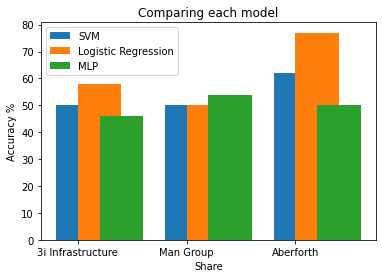

In [872]:
# Plotting accuracies for each model
# Code taken (pretty much) directly from https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/

X_axis = np.arange(len(share_names))

wid = 0.25

plt.bar(X_axis, svm_accuracies, 0.4, label = 'SVM')
plt.bar(X_axis + 0.2, lr_accuracies, 0.4, label = 'Logistic Regression')
plt.bar(X_axis + 0.4, list_mlp_accuracies, 0.4, label = 'MLP')
  
plt.xticks(X_axis, share_names)
plt.xlabel("Share")
plt.ylabel("Accuracy %")
plt.title("Comparing each model")
plt.legend()
plt.show()